In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Taking pictures

In [2]:
import sim as vrep
import time
import cv2
import numpy as np

vrep.simxFinish(-1)

clientID = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

# Pictures are stored in 'imgs' and their corresponding orientations are stored in 'orientations'
imgs = []
orientations = []

if clientID!=-1:
    # Handler for the camera
    res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
    _, v2 = vrep.simxGetObjectHandle(clientID, 'Pioneer_p3dx', vrep.simx_opmode_oneshot_wait)
    print ('Getting first image')
    err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
    vrep.simxGetObjectOrientation(clientID, v2, -1, vrep.simx_opmode_streaming)
    
    # Take p pictures
    p = 18
    i = 0
    while i < p:     
        err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
        if err == vrep.simx_return_ok:
            print ("image %d OK!!!"%i)
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            orientation = vrep.simxGetObjectOrientation(clientID, v2, -1, vrep.simx_opmode_streaming)
            imgs.append(img)
            orientations.append(orientation[1])
            # Show the images using Opencv (uncomment if you want to try it)
#            cv2.imshow('image',img)
#            if cv2.waitKey(1) & 0xFF == ord('q'):
#                break
            i+=1
        elif err == vrep.simx_return_novalue_flag:
            print ("no image yet")
            pass
        else:
          print (err)
        time.sleep(1)
else:
  print ("Failed to connect to remote API Server")
  vrep.simxFinish(clientID)

Getting first image
no image yet
image 0 OK!!!
image 1 OK!!!
image 2 OK!!!
image 3 OK!!!
image 4 OK!!!
image 5 OK!!!
image 6 OK!!!
image 7 OK!!!
image 8 OK!!!
image 9 OK!!!
image 10 OK!!!
image 11 OK!!!
image 12 OK!!!
image 13 OK!!!
image 14 OK!!!
image 15 OK!!!
image 16 OK!!!
image 17 OK!!!


[0.0033422198612242937, -0.00161345349624753, 1.1456159353256226]


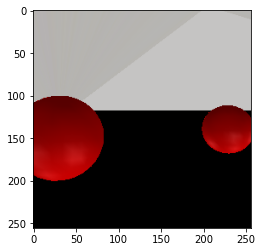

In [3]:
imshow(imgs[0])
print(orientations[0])

## Detecting circles

In [4]:
# Convert to gray scale
gray_imgs = []
Circles = []
for i in range(0, p):
    gray = cv2.cvtColor(imgs[i], cv2.COLOR_RGB2GRAY)
    gray = cv2.medianBlur(gray, 5)
    # Find circles in each pic using Hough Algorithm
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0] / 8, param1=30,param2=15,minRadius=10,maxRadius=0)
    c = []
    if circles is not None:
        for circle in circles[0, :]:
            # Skip any invalid circle
            if circle[1] < 125 or circle[1] > 160 or circle[0] < 30 or circle[0] > 220:
                continue
            c.append(circle)
    gray_imgs.append(gray)
    Circles.append(c)

149.5


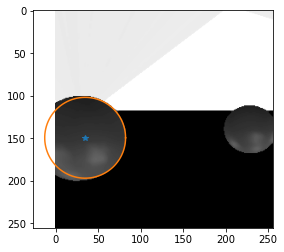

In [5]:
i = 0
imshow(gray_imgs[i], cmap='gray')
# plot circle
for circle in Circles[i]:
    s = linspace(0, 2*pi, 100)
    cx = cos(s)*circle[2] + circle[0]
    cy = sin(s)*circle[2] + circle[1]
    plot(circle[0],circle[1],'*')
    plot(cx, cy)
    print(circle[1])

## Mapping to world frame

In [6]:
u0, v0 = 132, 132
# degrees
fov = 60
# num of pixels in x-axis
npx = 264

# coordinates in the world frame
xs = []
ys = []

for i in range(0, p):
    for circle in Circles[i]:
        k = circle[2] / (1.5/2)
        xmax = npx / (2. * k)
        zc = xmax / tan(pi/6)
        xc = (circle[0] - u0) / k
        theta = orientations[i][2]
        x = zc * cos(theta) + xc * sin(theta)
        y = zc * sin(theta) - xc * cos(theta)
        xs.append(x)
        ys.append(y)
        # Print coordinates of detected cirlces (might have duplications) in the world frame
        print(x,y)

0.08646651150991946 3.9153108331126343
4.852941542841096 4.436933755434442
4.957167949380325 4.427233972197269
3.254326219735382 0.049257650972471645
2.8979700066829497 0.06753995003541169
4.950211984696896 -3.056387190477312
4.964728540250425 -3.108588772358948
1.7159567386710985 -7.062414896695426
1.814041714973758 -7.422381872171164
-2.441153075133448 -3.643883381705242
-5.497809281439126 -5.244641441408239
-2.4052772965482405 -3.610948101718253
-5.656247623600045 -5.330042555828558
-5.538645245264628 0.7657382342271462
-5.3018033796140145 0.7649717710639188
-3.8117301492949296 4.749207925360806
-3.7504433038431255 4.796335073905143
-0.05536760026214593 3.7742550840067097
-0.005468396312638435 3.7686430655507235
0.04631233082117059 3.7689878762914226


## Combining all in the grid map

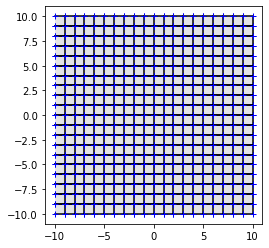

In [7]:
# Tha map is 20x20 sq meters
#Lets define a grid of nxn
n = 20
gmap = zeros(n*n) # the map is a grid of nxn

# x and y coordinates for the grid cells. Lowest and leftest point in the cell.
cell_w = 20/n
grid_x, grid_y = np.mgrid[-10:10:cell_w,-10:10:cell_w]
# Convert the matrix into a vector
grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

# Computes the four points of the square that composes a cell
def points_cell(x, y, d):    
    X = [x, x+d, x+d, x]
    Y = [y, y, y+d, y+d]
    return X, Y

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# plot each cell
for x, y in zip(grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='0.9')
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    
fig.canvas.draw()

In [43]:
l0 = (0.3/(1-0.3))  # Initial belief
gmap = l0 * ones(n*n)  # Initial belief

# For each cell, check if the circle is in it.
for i in range(n*n):
    x, y = grid_x[i], grid_y[i]
    X, Y = points_cell(x, y, cell_w)
    dists = np.array([])
    for xc, yc in zip(xs, ys):
        dist = sqrt((xc-X)**2 + (yc-Y)**2)
        dists = np.concatenate((dists, dist), axis=0)
        
    # Check if At least on of the borders is within a sphere
    if ((dists < (1.5/2)).any()):
        po = 0.8
        li = log(po / (1-po)) + gmap[i] - l0
        gmap[i] = li
    # no need to check fov, since it's 360 degrees
    else:
        po = 0.05
        li = log(po / (1-po)) + gmap[i] - l0
        gmap[i] = li
        pass

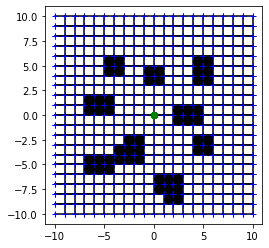

In [44]:
# gmap
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

# normalize gmap
gmap = gmap - min(gmap)
gmap = gmap / max(gmap)

# plot each cell
for c, x, y in zip(gmap, grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='%f'%(1-c))
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    plot(0,0, 'go')
    
fig.canvas.draw()